In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
%ls

analyse_emb_utt.ipynb
cmd.sh@
conf@
data/
db@
exp_vector_2spk/
local@
path.sh@
plot_resemblyzer.ipynb*
run_prepare_shared.log
run_prepare_shared.sh*
run_vector_2spk_baseline.adapt_npr.50epoch.inf_copk.log
run_vector_2spk_baseline.adapt_npr.50epoch.inf.log
run_vector_2spk_baseline.adapt_npr.50epoch.inf_nochunk.log
run_vector_2spk_baseline.adapt_npr.train.log
run_vector_2spk_baseline.inf_clusters.log
run_vector_2spk_baseline.inf_copkmeans.log
run_vector_2spk_baseline.inf_nochunk.log
run_vector_2spk_baseline.npr.inf_copkmeans.log
run_vector_2spk_baseline.npr.inf.log
run_vector_2spk_baseline.npr.inf_nocluster.log
run_vector_2spk_baseline.sh*
run_vector_2spk_baseline.train.log
run_vector_2spk_baseline.utt_inf.chunk.log
run_vector_2spk_baseline.utt_inf.nochunk.log
run_vector_2spk_baseline.utt_inf.sh*
sim_rir_8k.zip@
steps@
utils@


In [3]:
%ls exp_vector_2spk/diarize/infer/train-all-960_ns2_beta2_nu_3_20.dev-clean_ns2_beta2_500.vector_train_2spk_l2norm.avg68-83.vector_infer_2spk_l2norm/test-clean/

1089-134686-0000.h5  2961-960-0000.h5     61-70970-0004.h5
1089-134686-0001.h5  2961-960-0001.h5     61-70970-0005.h5
1089-134686-0002.h5  2961-960-0002.h5     61-70970-0006.h5
1089-134686-0003.h5  2961-960-0003.h5     61-70970-0007.h5
1089-134686-0004.h5  2961-960-0004.h5     61-70970-0008.h5
1089-134686-0005.h5  2961-960-0005.h5     61-70970-0009.h5
1089-134686-0006.h5  2961-960-0006.h5     61-70970-0010.h5
1089-134686-0007.h5  2961-960-0007.h5     61-70970-0011.h5
1089-134686-0008.h5  2961-960-0008.h5     61-70970-0012.h5
1089-134686-0009.h5  2961-960-0009.h5     61-70970-0013.h5
1089-134686-0010.h5  2961-960-0010.h5     61-70970-0014.h5
1089-134686-0011.h5  2961-960-0011.h5     61-70970-0015.h5
1089-134686-0012.h5  2961-960-0012.h5     61-70970-0016.h5
1089-134686-0013.h5  2961-960-0013.h5     61-70970-0017.h5
1089-134686-0014.h5  2961-960-0014.h5     61-70970-0018.h5
1089-134686-0015.h5  2961-960-0015.h5     61-70970-0019.h5
1089-134686-0016.h5  2961-960-0016.h5     61-70970-0020.

In [4]:
import os
from pathlib import Path

EXP_BASE="exp_vector_2spk/diarize"
INFER_BASE=os.path.join(EXP_BASE, "infer/train-all-960_ns2_beta2_nu_3_20.dev-clean_ns2_beta2_500.vector_train_2spk_l2norm.avg68-83.vector_infer_2spk_l2norm/test-clean")
data_dir = Path(INFER_BASE)

h5_paths = list(data_dir.glob("*.h5"))
speakers = [fpath.stem.split("-")[0] for fpath in h5_paths]

In [5]:
[(spk, wavfile.name) for spk, wavfile in zip(speakers, h5_paths)]

[('1089', '1089-134686-0002.h5'),
 ('1089', '1089-134686-0014.h5'),
 ('1188', '1188-133604-0021.h5'),
 ('1188', '1188-133604-0030.h5'),
 ('121', '121-121726-0011.h5'),
 ('121', '121-121726-0014.h5'),
 ('121', '121-123859-0004.h5'),
 ('121', '121-127105-0011.h5'),
 ('121', '121-127105-0015.h5'),
 ('1221', '1221-135766-0004.h5'),
 ('1221', '1221-135767-0009.h5'),
 ('1284', '1284-1180-0029.h5'),
 ('1320', '1320-122617-0014.h5'),
 ('1320', '1320-122617-0023.h5'),
 ('1580', '1580-141083-0002.h5'),
 ('1580', '1580-141083-0032.h5'),
 ('1580', '1580-141084-0008.h5'),
 ('1580', '1580-141084-0027.h5'),
 ('1580', '1580-141084-0039.h5'),
 ('1995', '1995-1837-0009.h5'),
 ('1995', '1995-1837-0019.h5'),
 ('1995', '1995-1837-0024.h5'),
 ('2300', '2300-131720-0038.h5'),
 ('237', '237-126133-0016.h5'),
 ('237', '237-126133-0025.h5'),
 ('237', '237-134500-0033.h5'),
 ('237', '237-134500-0042.h5'),
 ('260', '260-123286-0004.h5'),
 ('2830', '2830-3979-0006.h5'),
 ('2830', '2830-3980-0017.h5'),
 ('2830', '2

In [6]:
import h5py
import numpy as np

spk2_h5 = [h5py.File(f, 'r') for f in h5_paths]

In [7]:
print("T_hat:", spk2_h5[0]["T_hat"][:].shape)
print("out_spks:", spk2_h5[0]["out_spks"][:].shape)
print("chunk_sizes:", spk2_h5[0]["chunk_sizes"][:])

T_hat: (133, 2)
out_spks: (2, 256)
chunk_sizes: [133]


In [8]:
def batch_silence_detect(array_list, threshold=0.05):
    """Return silence index for each item in the array_list.
    Mean value for each item below threshold is considered as silence.

    Args:
        array_list (List[np.ndarray]): list of shape (frames, speakers)

    Returns:
        silence_ids (List[Set[int]])
    """
    silence_ids = []
    for X in array_list:
        mean_logits = np.mean(X, axis=0) # shape: (speakers)
        silence_set = {i for i, logit in enumerate(mean_logits) if logit < threshold}
        silence_ids.append(silence_set)
    return silence_ids

In [9]:
list_T_hat = [h5["T_hat"][:] for h5 in spk2_h5]
batch_silence_detect(list_T_hat)

[set(),
 set(),
 set(),
 {1},
 set(),
 {1},
 {1},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {1},
 set(),
 set(),
 set(),
 set(),
 {1},
 set(),
 set(),
 {1},
 set(),
 set(),
 set(),
 set(),
 set(),
 {1},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {1},
 set(),
 {1},
 set(),
 set(),
 set(),
 {1},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {1}

In [10]:
np.mean(spk2_h5[0]["T_hat"][:], axis=0)

array([0.8084575 , 0.66987264], dtype=float32)

In [20]:
T_means = [np.mean(_T, axis=0).tolist() for _T in list_T_hat]
T_means_big = np.array([max(_means) for _means in T_means])
T_means_small = np.array([min(_means) for _means in T_means])
T_means_big_id = np.array([np.argmax(_means) for _means in T_means])
T_means_small_id = np.array([np.argmin(_means) for _means in T_means])

In [22]:
print(f"dia  tag means: {T_means[:20]}")
print(f"dia  tag means(bigger): {T_means_big[:20]}")
print(f"dia  tag means(smaller): {T_means_small[:20]}")
print(f"dia  tag means index (bigger): {T_means_big_id[:20]}")
print(f"dia  tag means index (bigger): {T_means_small_id[:20]}")

dia  tag means: [[0.8084574937820435, 0.6698726415634155], [0.853754997253418, 0.16264814138412476], [0.8043349981307983, 0.678695797920227], [0.7082722783088684, 0.008016363717615604], [0.8588464856147766, 0.05148818716406822], [0.8860183358192444, 0.00048544586752541363], [0.9055349230766296, 0.039739660918712616], [0.8732637166976929, 0.614932656288147], [0.9689005613327026, 0.2455594837665558], [0.8761855959892273, 0.2590351700782776], [0.8819783329963684, 0.3222784698009491], [0.8650086522102356, 0.4039379060268402], [0.8731170296669006, 0.1035522073507309], [0.8857751488685608, 0.3345801830291748], [0.8748500347137451, 0.09745081514120102], [0.8116626143455505, 0.48510292172431946], [0.8689895272254944, 0.4273524582386017], [0.6568068861961365, 0.14606520533561707], [0.948839545249939, 0.08547820895910263], [0.8852050304412842, 0.7274904251098633]]
dia  tag means(bigger): [0.80845749 0.853755   0.804335   0.70827228 0.85884649 0.88601834
 0.90553492 0.87326372 0.96890056 0.876185

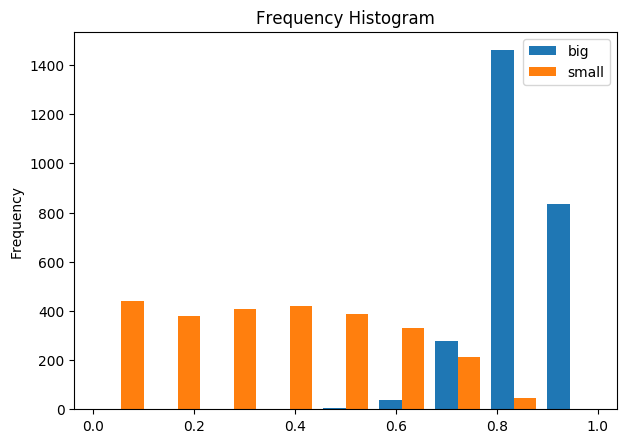

In [23]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

bins = np.linspace(0, 1, 10)
plt.hist([T_means_big, T_means_small], bins=bins, label=['big', 'small'])
plt.legend(loc='best')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')
plt.show()

Embedding with higher means should be the speaker embedding, with lower means is silent(bg). Since we train the model with simulated data where a large portion of overlapping speech, therefore the overall value if high.
A good silence detection value suggest by this plot might be some value around 0.6-0.8.

In [24]:
spks_embs = [h5["out_spks"][:] for h5 in spk2_h5]
spks_embs[0].shape

(2, 256)

In [28]:
print(f"{len(spks_embs)}")
print(f"{len(T_means_small_id)}")
print(f"{len(speakers)}")

2620
2620
2620


In [29]:
spks_embs_big = [embs[idx] for embs, idx in zip(spks_embs, T_means_big_id)]
spks_embs_small = [embs[idx] for embs, idx in zip(spks_embs, T_means_small_id)]

In [30]:
spks_embs_big[0].shape

(256,)

In [31]:
np_spks_embs_big = np.stack(spks_embs_big)
np_spks_embs_small = np.stack(spks_embs_small)
print(np_spks_embs_big.shape)
print(np_spks_embs_small.shape)

(2620, 256)
(2620, 256)


In [32]:
speakers_set = set(speakers)
print(f"total speaker: {len(speakers_set)}")

total speaker: 40


In [33]:
speakers_map = {}
for idx, spk_name in enumerate(speakers):
    if spk_name not in speakers_map:
        speakers_map[spk_name] = [idx]
    else:
        speakers_map[spk_name].append(idx)
print(f"total speaker: {len(speakers_map.keys())}")

total speaker: 40


In [34]:
speakers_map

{'1089': [0,
  1,
  91,
  93,
  94,
  182,
  187,
  188,
  266,
  268,
  357,
  438,
  445,
  543,
  544,
  622,
  632,
  635,
  642,
  759,
  838,
  850,
  853,
  864,
  927,
  939,
  957,
  1016,
  1019,
  1108,
  1120,
  1126,
  1283,
  1286,
  1293,
  1298,
  1379,
  1383,
  1406,
  1414,
  1432,
  1437,
  1446,
  1526,
  1638,
  1647,
  1668,
  1712,
  1772,
  1831,
  1844,
  1944,
  2095,
  2120,
  2149,
  2171,
  2199,
  2204,
  2209,
  2265,
  2328,
  2359,
  2521,
  2532],
 '1188': [2,
  3,
  92,
  189,
  262,
  265,
  267,
  356,
  442,
  446,
  545,
  639,
  736,
  743,
  745,
  756,
  852,
  928,
  931,
  1027,
  1201,
  1202,
  1211,
  1265,
  1294,
  1393,
  1739,
  1754,
  1786,
  1804,
  1816,
  1949,
  1982,
  2013,
  2075,
  2102,
  2226,
  2271,
  2274,
  2322,
  2418,
  2531,
  2534,
  2577,
  2596],
 '121': [4,
  5,
  6,
  7,
  8,
  95,
  185,
  190,
  269,
  346,
  613,
  624,
  638,
  643,
  766,
  868,
  933,
  936,
  937,
  949,
  961,
  1118,
  1175,
  1193,
 

In [35]:
from sklearn.manifold import TSNE

def dimension_reduce_TSNE(embeds):
    tsne2d = TSNE(n_components=2)
    embeds_2d = tsne2d.fit_transform(embeds)
    return embeds_2d

In [45]:
def plot2D_by_category(X_2d, category_map, num2plot=None, with_legend=False):
    category_names = list(category_map.keys())
    if num2plot is not None:
        category_names = category_names[:num2plot]
        print(f"only plot first {len(category_names)} class")
    colors = [np.random.rand(3,) for i in category_names]
    plt.figure(figsize=(8, 8))
    for color, target_name in zip(colors, category_names):
        cluster_ids = category_map[target_name]
        plt.scatter(X_2d[cluster_ids, 0], X_2d[cluster_ids, 1], color=color, lw=2, label=target_name)
    plt.title("speaker audio embedding 2D visualize")
    if with_legend:
        plt.legend(loc='best')
    plt.show()

In [46]:
np_spks_embs_big_2D = dimension_reduce_TSNE(np_spks_embs_big)
print(np_spks_embs_big_2D.shape)

(2620, 2)


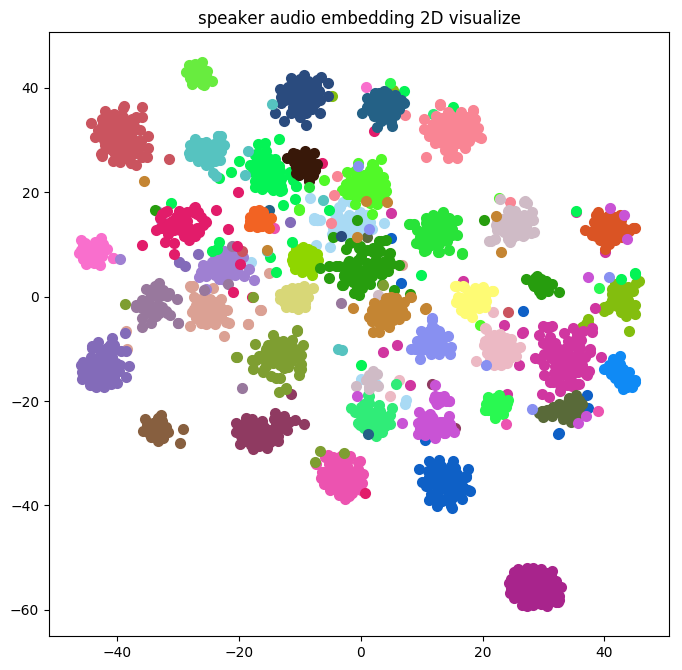

In [47]:
plot2D_by_category(np_spks_embs_big_2D, speakers_map)

only plot first 10 class


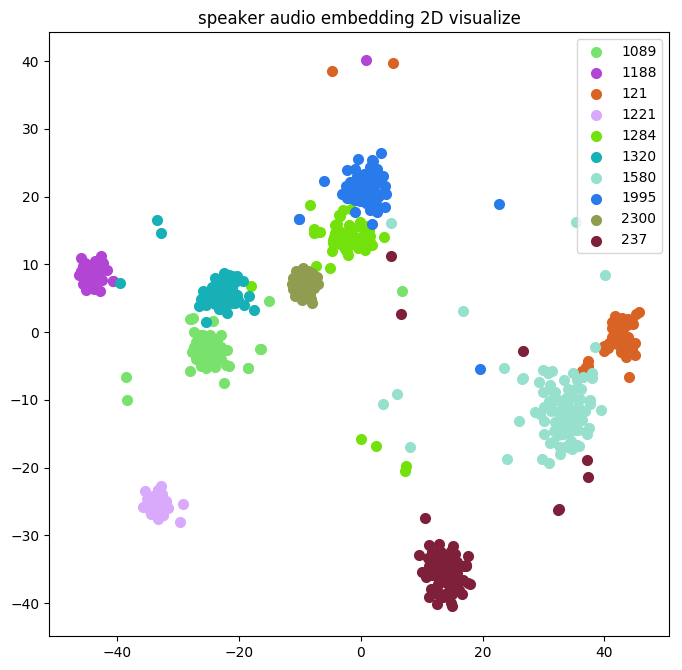

In [48]:
plot2D_by_category(np_spks_embs_big_2D, speakers_map, num2plot=10, with_legend=True)

(2620, 2)


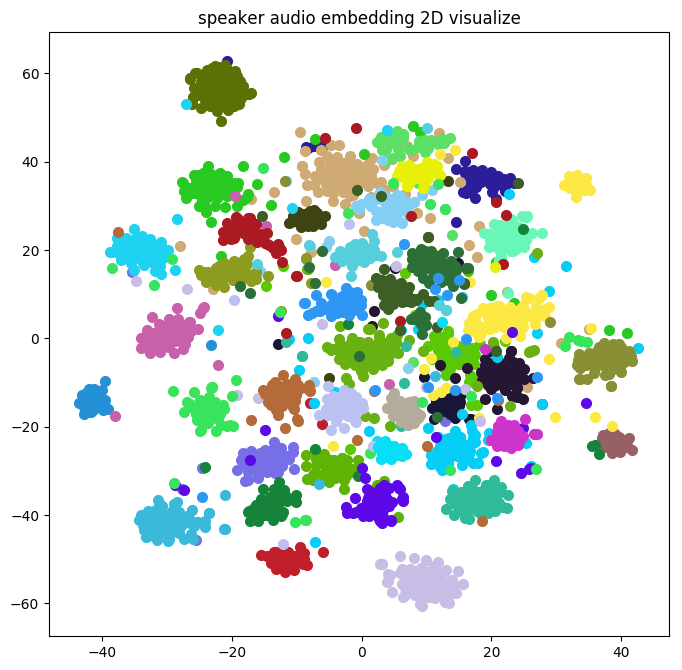

In [49]:
np_spks_embs_small_2D = dimension_reduce_TSNE(np_spks_embs_small)
print(np_spks_embs_small_2D.shape)
plot2D_by_category(np_spks_embs_small_2D, speakers_map)

only plot first 10 class


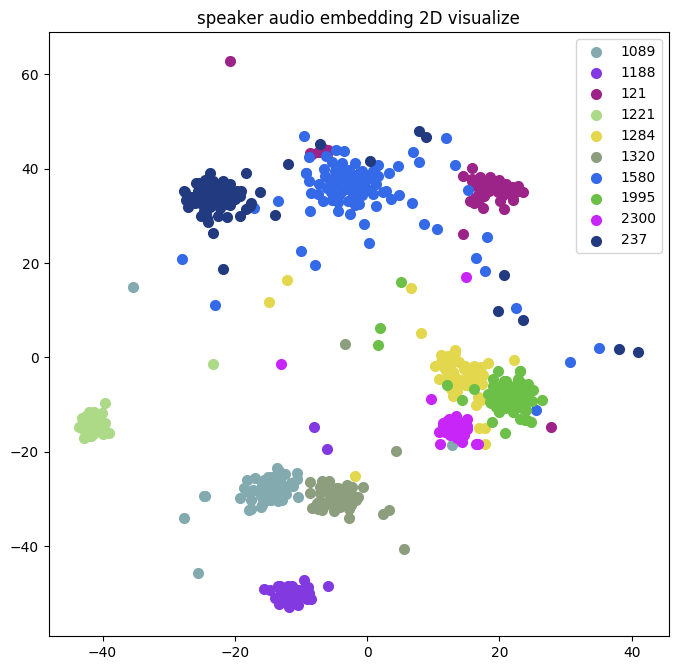

In [50]:
plot2D_by_category(np_spks_embs_small_2D, speakers_map, num2plot=10, with_legend=True)

In [51]:
def joint_plot2D_by_category(X1_2d, X2_2d, category_map, num2plot=None, with_legend=False):
    category_names = list(category_map.keys())
    if num2plot is not None:
        category_names = category_names[:num2plot]
        print(f"only plot first {len(category_names)} class")
    colors = [np.random.rand(3,) for i in category_names]
    plt.figure(figsize=(8, 8))
    for color, target_name in zip(colors, category_names):
        cluster_ids = category_map[target_name]
        plt.scatter(X1_2d[cluster_ids, 0], X1_2d[cluster_ids, 1], color=color, lw=2, label=target_name)
        plt.scatter(X2_2d[cluster_ids, 0], X2_2d[cluster_ids, 1], color=color, lw=2, label=target_name)
    plt.title("speaker audio embedding 2D visualize")
    if with_legend:
        plt.legend(loc='best')
    plt.show()

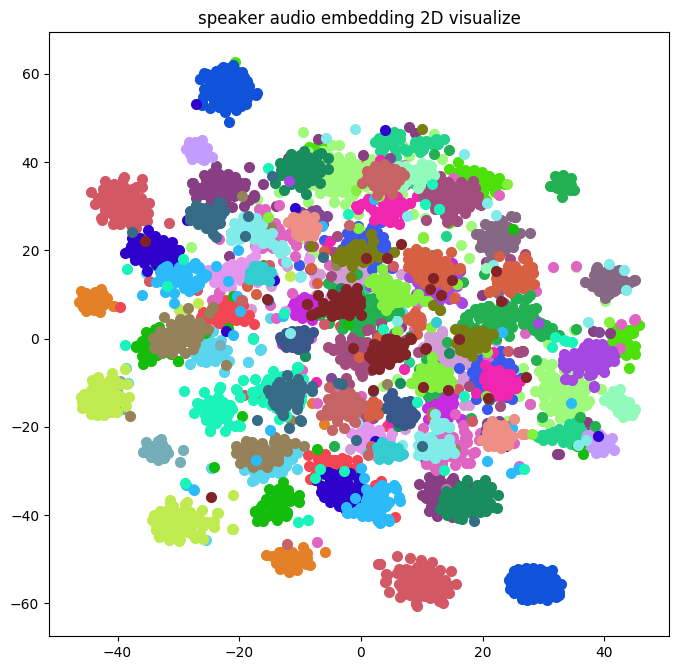

In [52]:
joint_plot2D_by_category(np_spks_embs_big_2D, np_spks_embs_small_2D, speakers_map)

only plot first 10 class


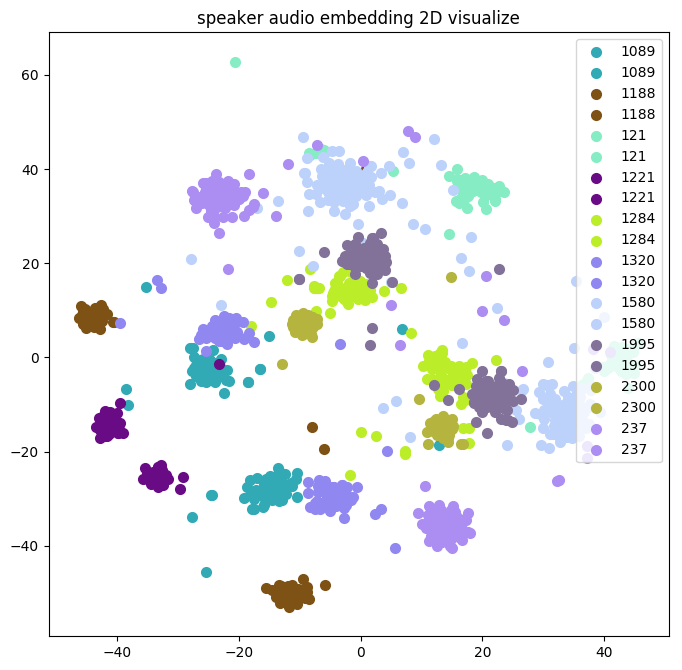

In [53]:
joint_plot2D_by_category(np_spks_embs_big_2D, np_spks_embs_small_2D, speakers_map, num2plot=10, with_legend=True)

only plot first 5 class


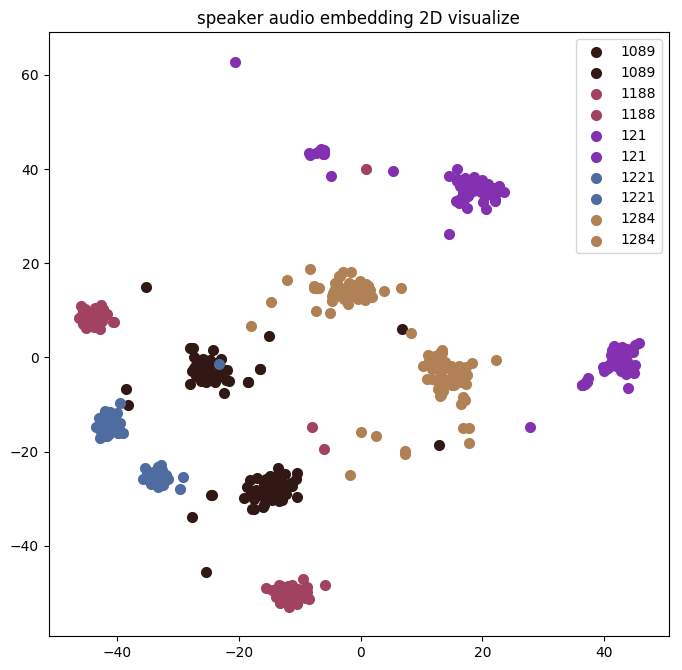

In [54]:
joint_plot2D_by_category(np_spks_embs_big_2D, np_spks_embs_small_2D, speakers_map, num2plot=5, with_legend=True)

## Summary
The speaker embeddings dimension reduced by T-SNE can be plot and showed clustered by different speaker if we consider that correspond to higher diarization result, since the lower correspond to silence (which plot indicate it include some carateristic of that speaker as showed symmetrical which may due to different TSNE operation)

In [55]:
_cut_point = len(np_spks_embs_big)
np_spks_embs_all = np.concatenate([np_spks_embs_big, np_spks_embs_small])
np_spks_embs_all_2D = dimension_reduce_TSNE(np_spks_embs_all)
print(_cut_point)
print(np_spks_embs_all.shape)
print(np_spks_embs_all_2D.shape)

2620
(5240, 256)
(5240, 2)


In [56]:
_np_spks_embs_big_2D = np_spks_embs_all_2D[:_cut_point]
_np_spks_embs_small_2D = np_spks_embs_all_2D[_cut_point:]
print(_np_spks_embs_big_2D.shape)
print(_np_spks_embs_small_2D.shape)

(2620, 2)
(2620, 2)


only plot first 5 class


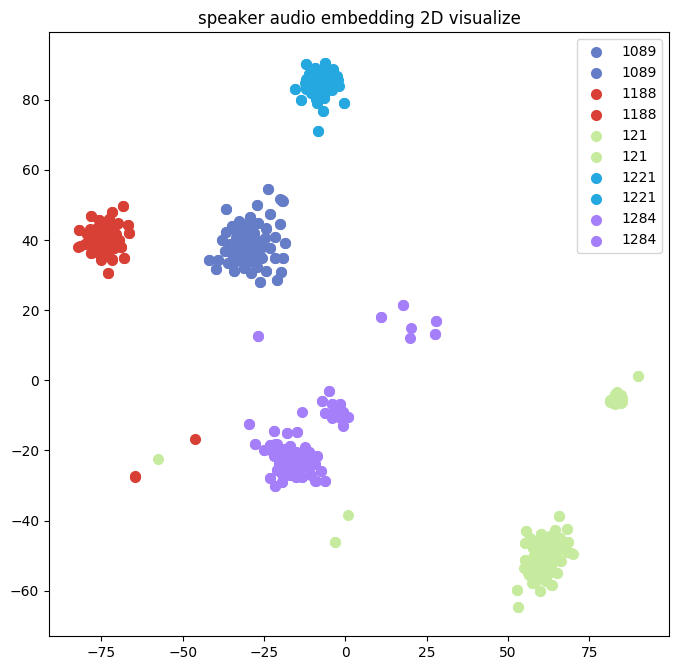

In [57]:
joint_plot2D_by_category(_np_spks_embs_big_2D, _np_spks_embs_small_2D, speakers_map, num2plot=5, with_legend=True)

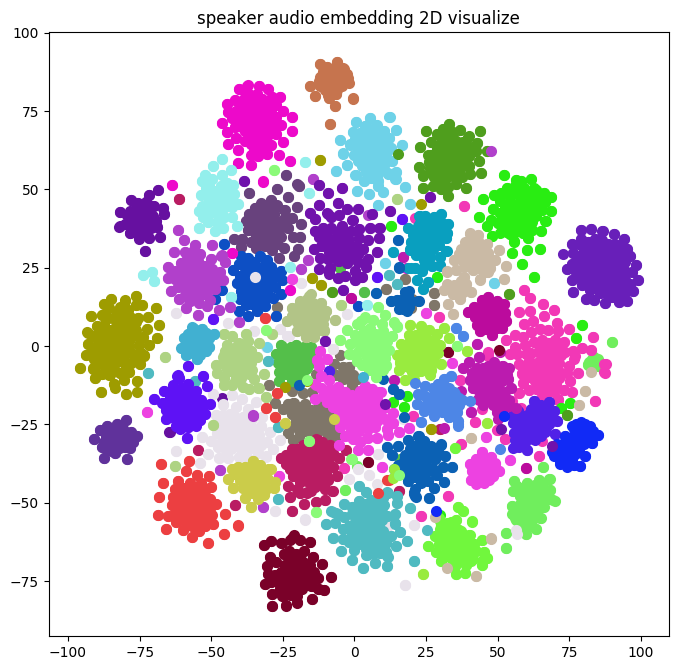

In [58]:
joint_plot2D_by_category(_np_spks_embs_big_2D, _np_spks_embs_small_2D, speakers_map)

## Conclusion
The speaker embeddings dimension reduced with a single T-SNE showing nice cluster boundaries even with silent speaker (which embeds part of activity of active speaker) indicating a nice capacity in extrait speaker embeddings for clean utterance.

Question: How will this become if the speech is noised and overlapped by multiple speaker?